In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import data

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.decomposition import TruncatedSVD

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [14]:
X_train, X_test, y_train, y_test, label_dict = data.load_data()

count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

smote = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)
smote_tomek = SMOTETomek(random_state=42)

In [15]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

In [16]:
results = []

def train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name):
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    if resampling_method:
        X_resampled, y_resampled = resampling_method.fit_resample(X_train_vec, y_train)
    else:
        X_resampled, y_resampled = X_train_vec, y_train

    if classifier_name == 'LightGBM':
        X_resampled = X_resampled.astype('float32')
        X_test_vec = X_test_vec.astype('float32')

    classifier.fit(X_resampled, y_resampled)
    y_pred = classifier.predict(X_test_vec)

    report = classification_report(y_test, y_pred, output_dict=True)
    acc = accuracy_score(y_test, y_pred)
    results.append({
        'Vectorizer': vectorizer_name,
        'Resampling': resampling_name,
        'Classifier': classifier_name,
        'Accuracy': acc,
        'Classification Report': report
    })

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values())
    plt.title(f'Confusion Matrix: {vectorizer_name} + {classifier_name} ({resampling_name})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## CountVectorizer

In [17]:
vectorizer_name = 'CountVectorizer'
vectorizer = count_vectorizer

Training: CountVectorizer + Random Forest (Original)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

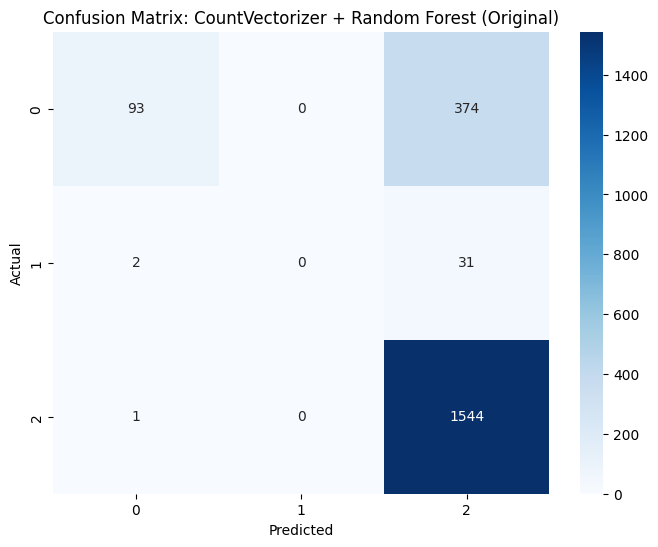

Training: CountVectorizer + XGBoost (Original)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


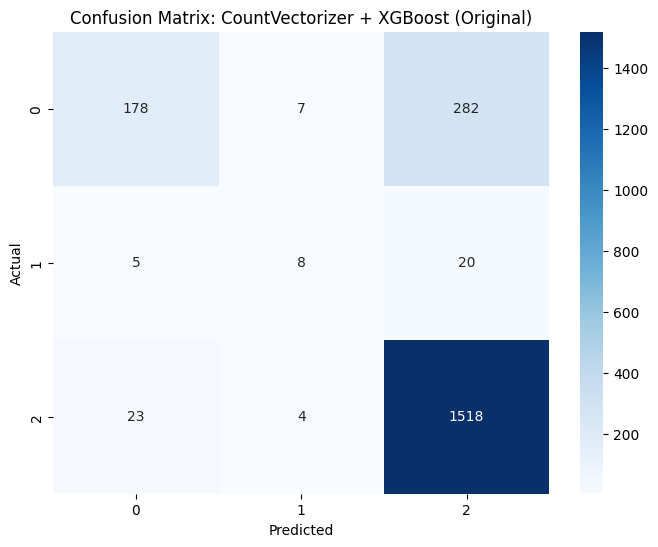

Training: CountVectorizer + LightGBM (Original)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3482
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 1183
[LightGBM] [Info] Start training from score -1.476166
[LightGBM] [Info] Start training from score -4.118976
[LightGBM] [Info] Start training from score -0.280737


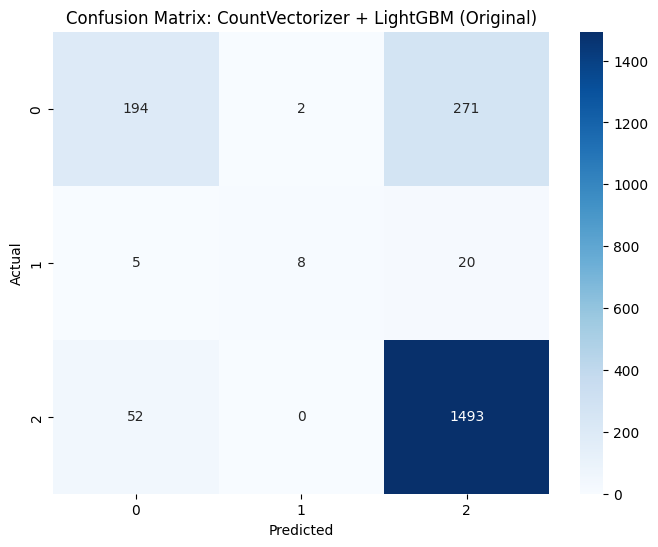

Training: CountVectorizer + Logistic Regression (Original)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

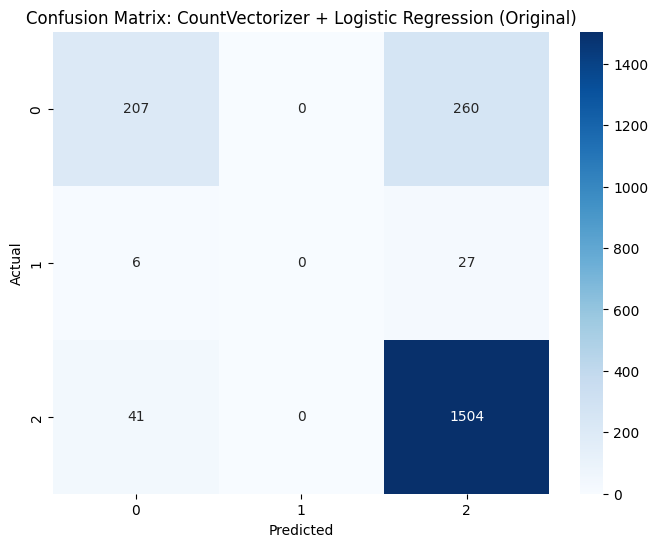

In [18]:
# Original data
resampling_name = 'Original'
resampling_method = None
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

Training: CountVectorizer + Random Forest (SMOTE)


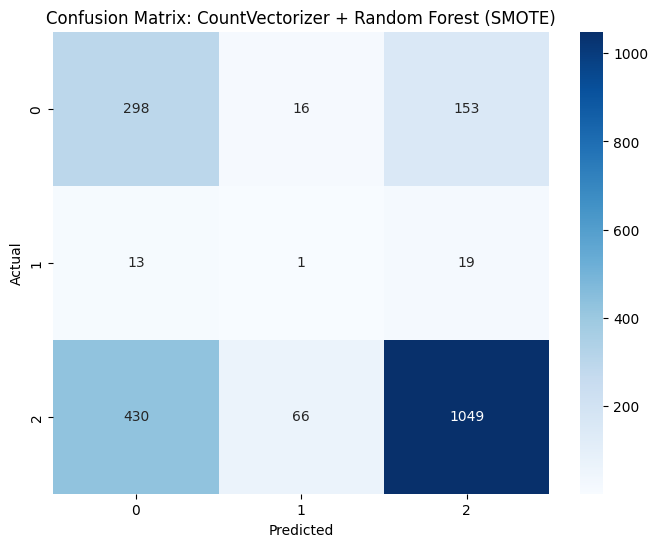

Training: CountVectorizer + XGBoost (SMOTE)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


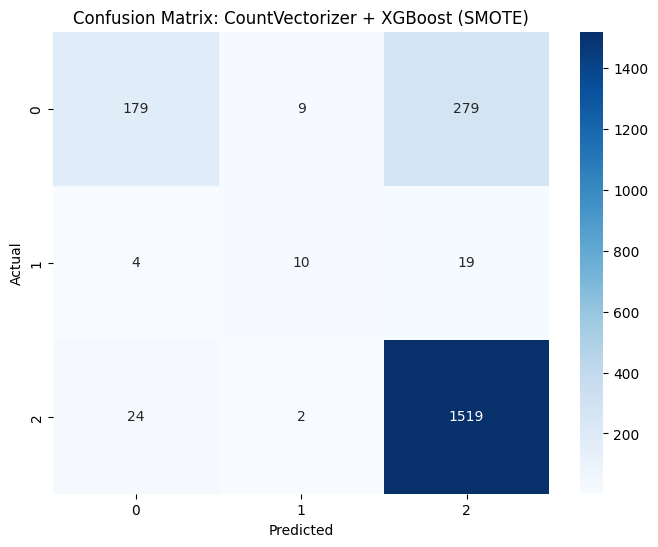

Training: CountVectorizer + LightGBM (SMOTE)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 1283
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


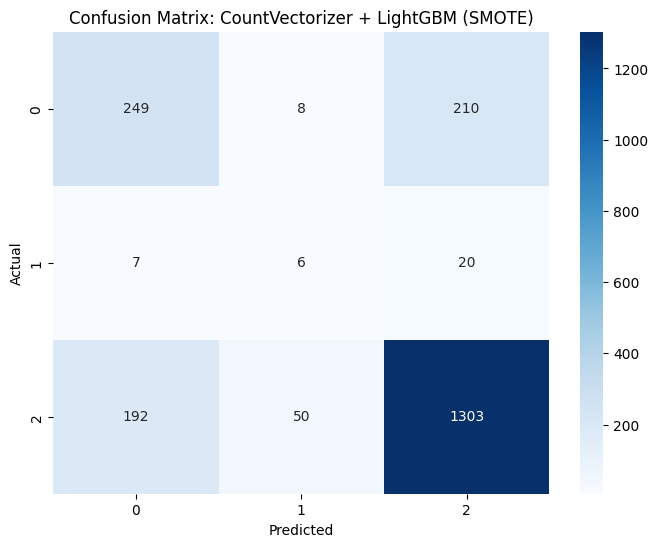

Training: CountVectorizer + Logistic Regression (SMOTE)


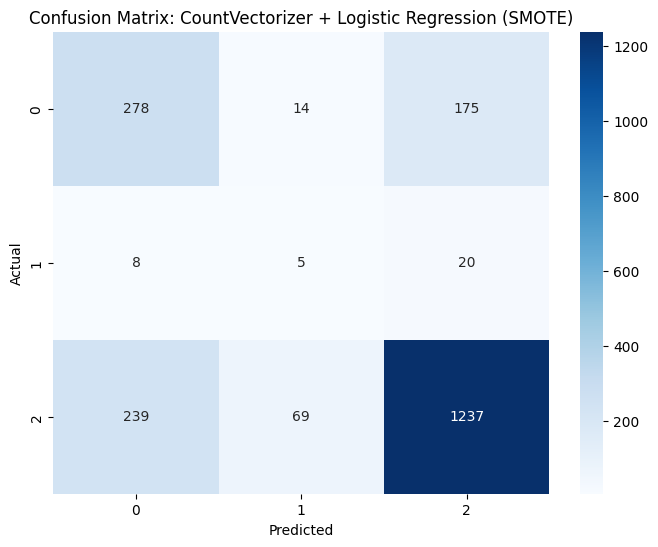

In [19]:
# SMOTE resampling
resampling_name = 'SMOTE'
resampling_method = smote
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

Training: CountVectorizer + Random Forest (Undersample)


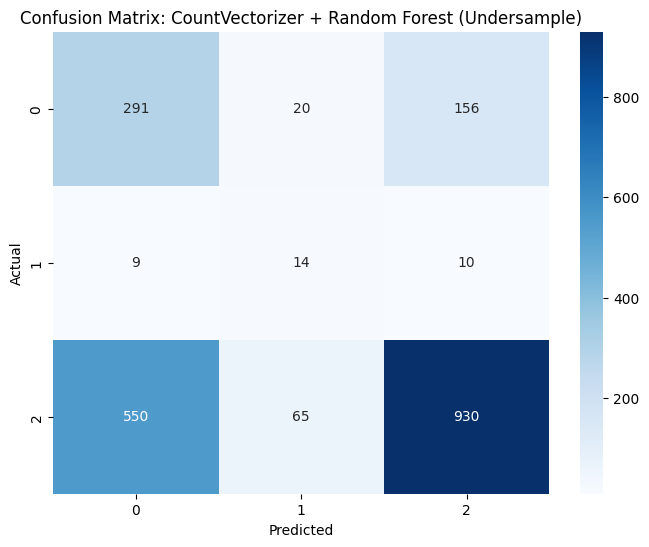

Training: CountVectorizer + XGBoost (Undersample)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


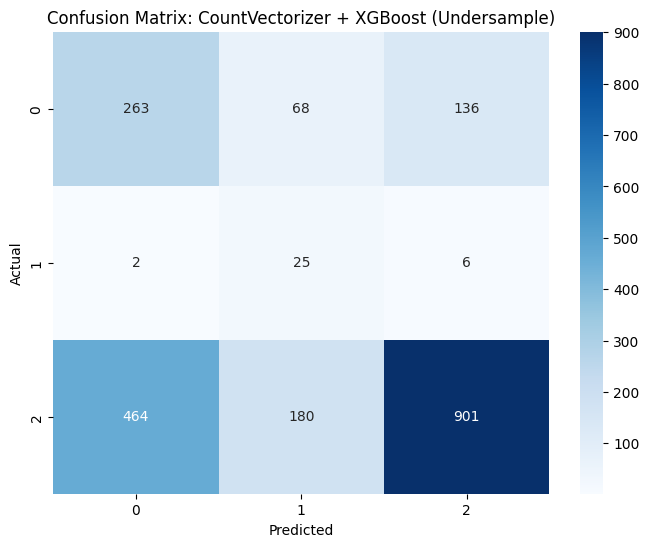

Training: CountVectorizer + LightGBM (Undersample)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 33
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

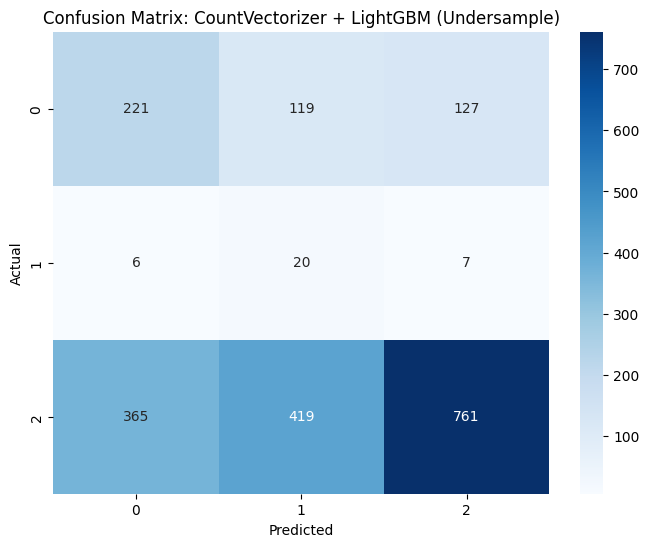

Training: CountVectorizer + Logistic Regression (Undersample)


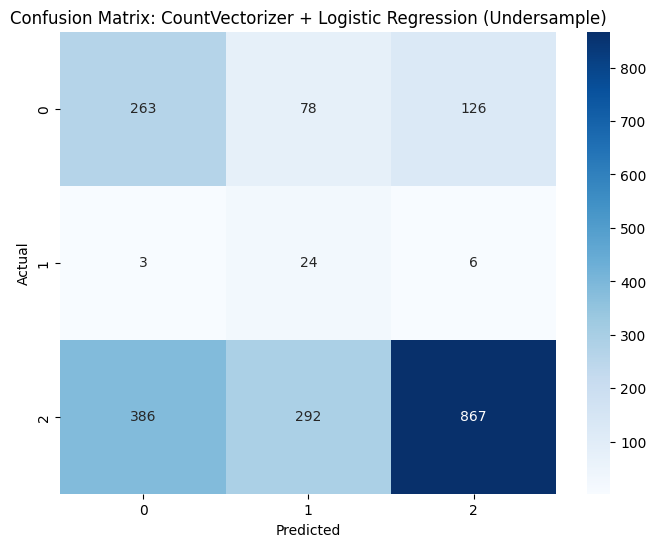

In [20]:
# Undersampling
resampling_name = 'Undersample'
resampling_method = under_sampler
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

Training: CountVectorizer + Random Forest (SMOTE+Tomek)


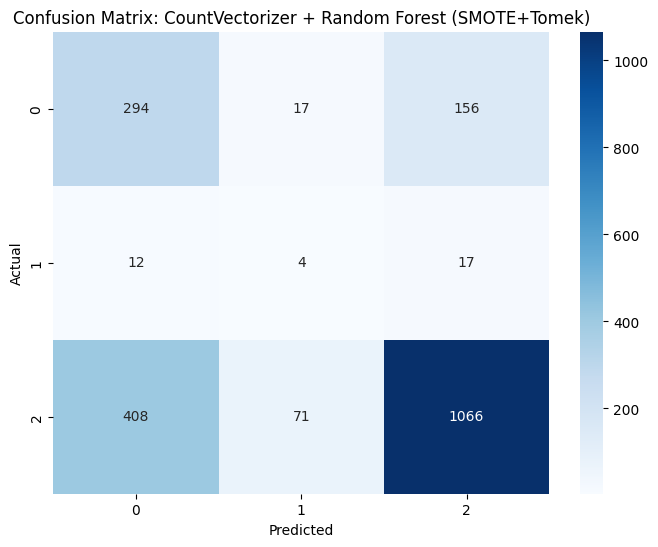

Training: CountVectorizer + XGBoost (SMOTE+Tomek)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


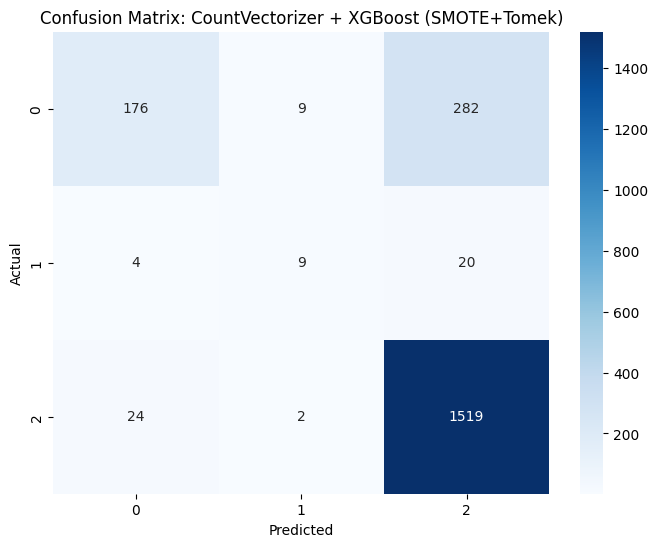

Training: CountVectorizer + LightGBM (SMOTE+Tomek)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3808
[LightGBM] [Info] Number of data points in the train set: 18525, number of used features: 1282
[LightGBM] [Info] Start training from score -1.098774
[LightGBM] [Info] Start training from score -1.098288
[LightGBM] [Info] Start training from score -1.098774


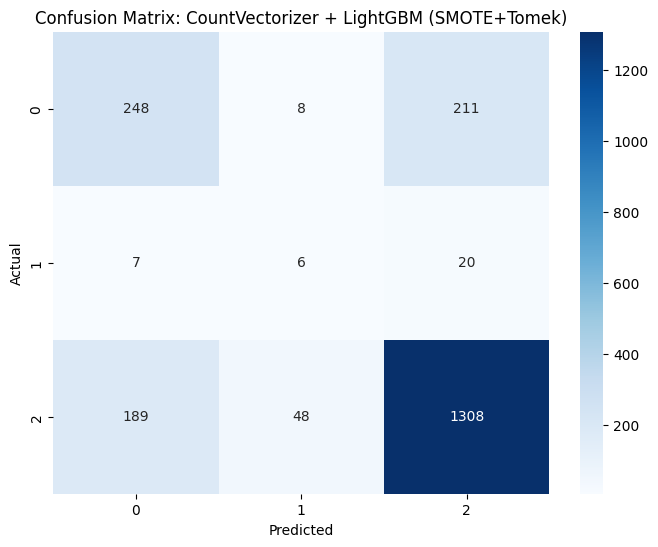

Training: CountVectorizer + Logistic Regression (SMOTE+Tomek)


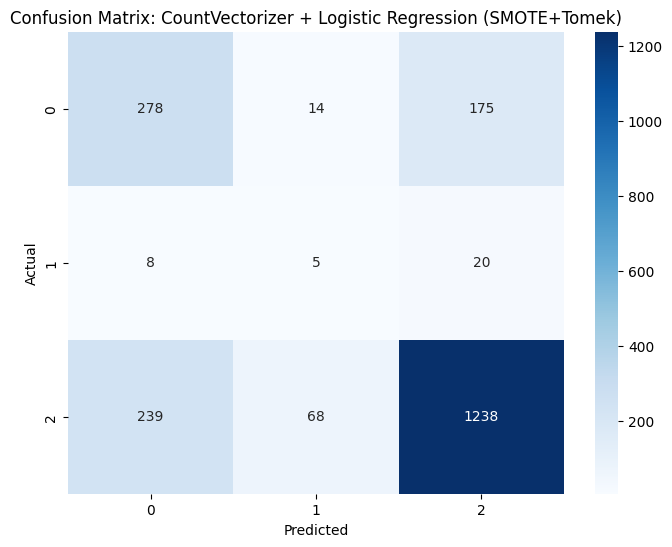

In [21]:
# SMOTE+Tomek resampling
resampling_name = 'SMOTE+Tomek'
resampling_method = smote_tomek
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

## TfidfVectorizer

In [22]:
vectorizer_name = 'TfidfVectorizer'
vectorizer = tfidf_vectorizer

Training: TfidfVectorizer + Random Forest (Original)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

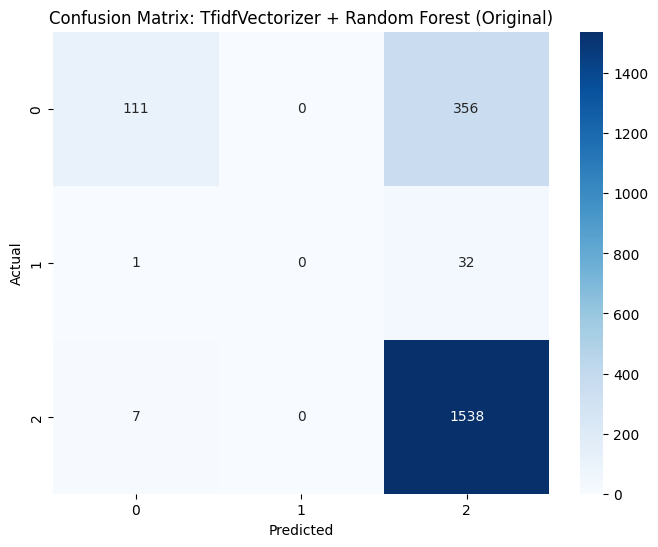

Training: TfidfVectorizer + XGBoost (Original)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


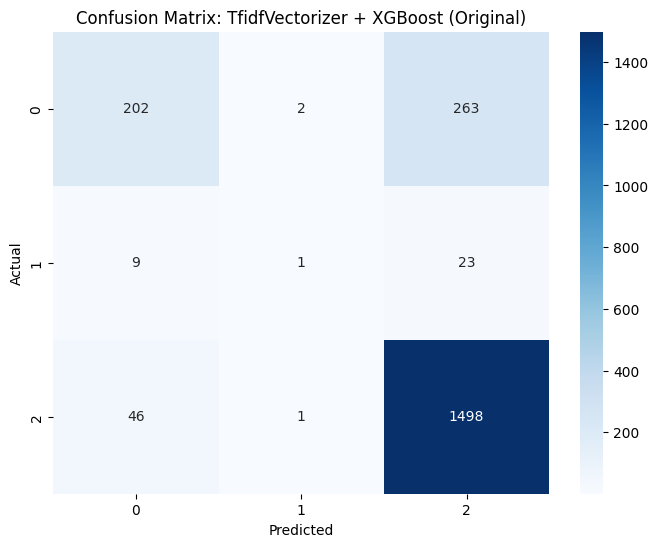

Training: TfidfVectorizer + LightGBM (Original)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27534
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 1183
[LightGBM] [Info] Start training from score -1.476166
[LightGBM] [Info] Start training from score -4.118976
[LightGBM] [Info] Start training from score -0.280737


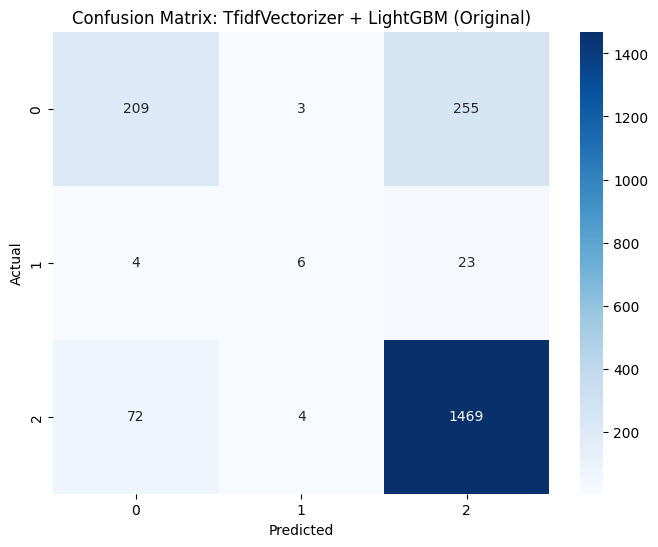

Training: TfidfVectorizer + Logistic Regression (Original)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

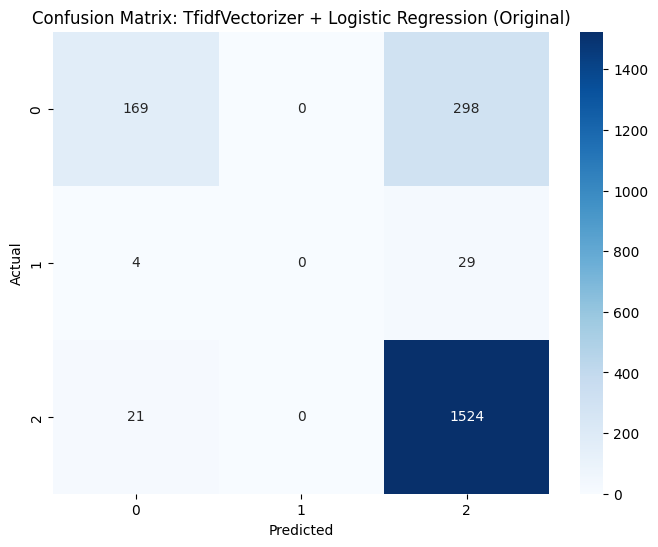

In [23]:
# Original data
resampling_name = 'Original'
resampling_method = None
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

Training: TfidfVectorizer + Random Forest (SMOTE)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

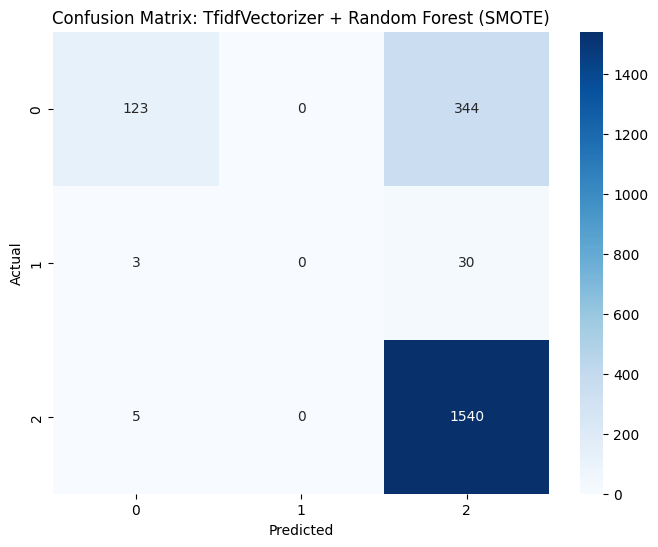

Training: TfidfVectorizer + XGBoost (SMOTE)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


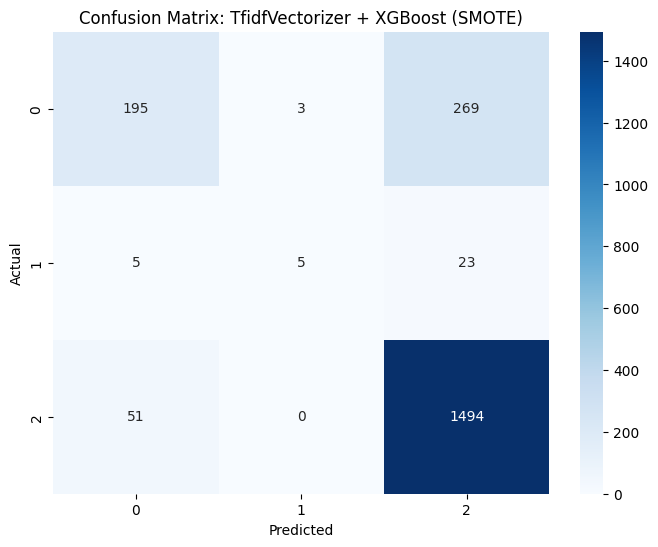

Training: TfidfVectorizer + LightGBM (SMOTE)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231150
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 7229
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


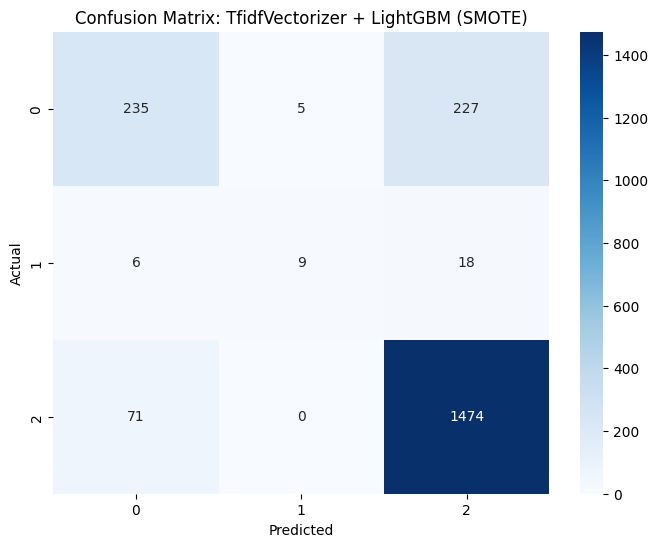

Training: TfidfVectorizer + Logistic Regression (SMOTE)


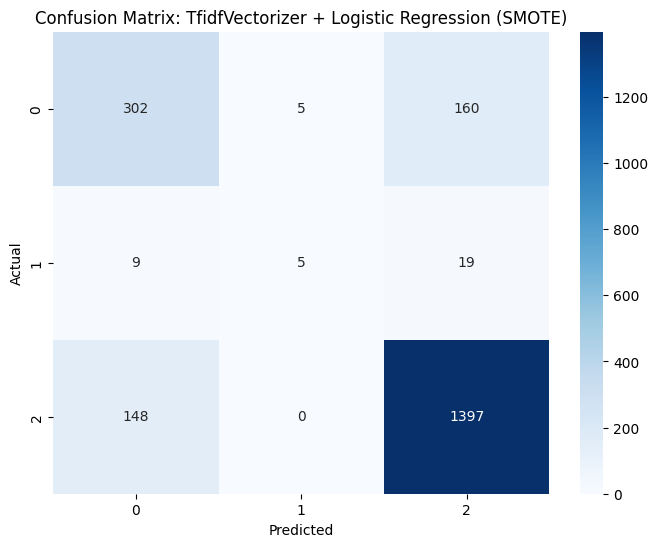

In [24]:
# SMOTE resampling
resampling_name = 'SMOTE'
resampling_method = smote
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

Training: TfidfVectorizer + Random Forest (Undersample)


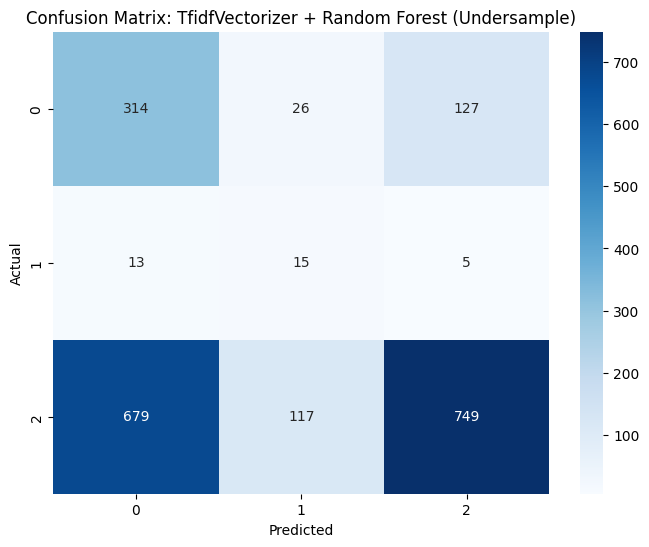

Training: TfidfVectorizer + XGBoost (Undersample)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


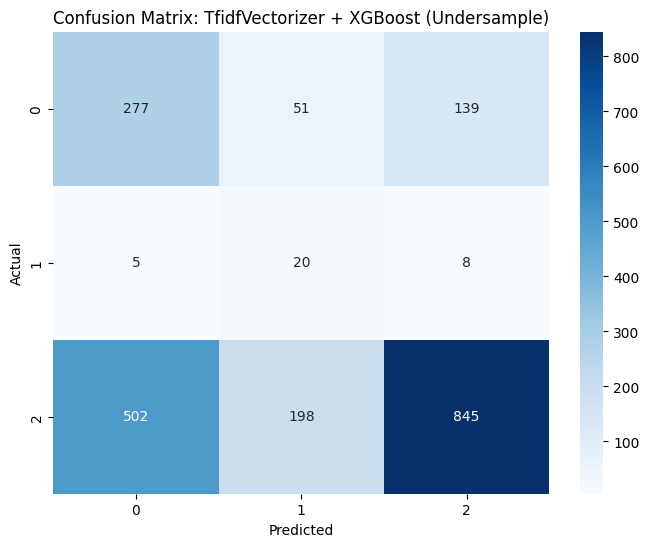

Training: TfidfVectorizer + LightGBM (Undersample)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 33
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

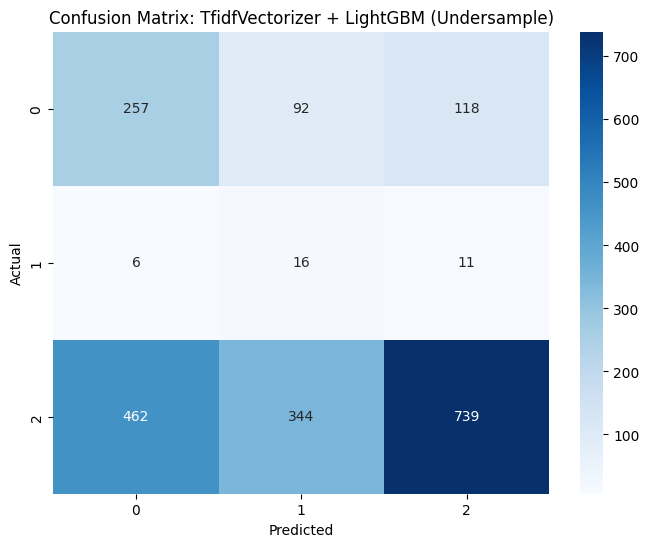

Training: TfidfVectorizer + Logistic Regression (Undersample)


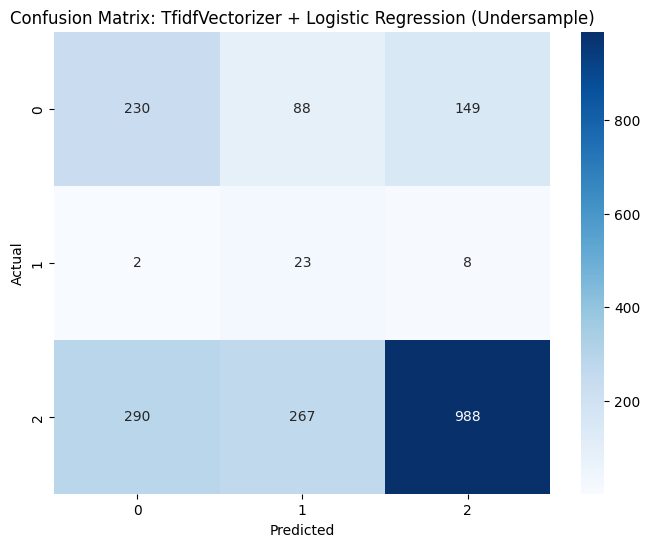

In [25]:
# Undersampling
resampling_name = 'Undersample'
resampling_method = under_sampler
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

Training: TfidfVectorizer + Random Forest (SMOTE+Tomek)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

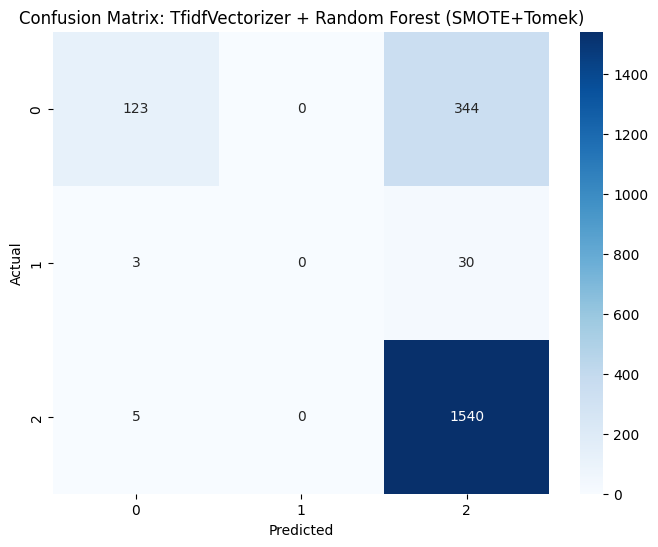

Training: TfidfVectorizer + XGBoost (SMOTE+Tomek)


c:\Users\ekinc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


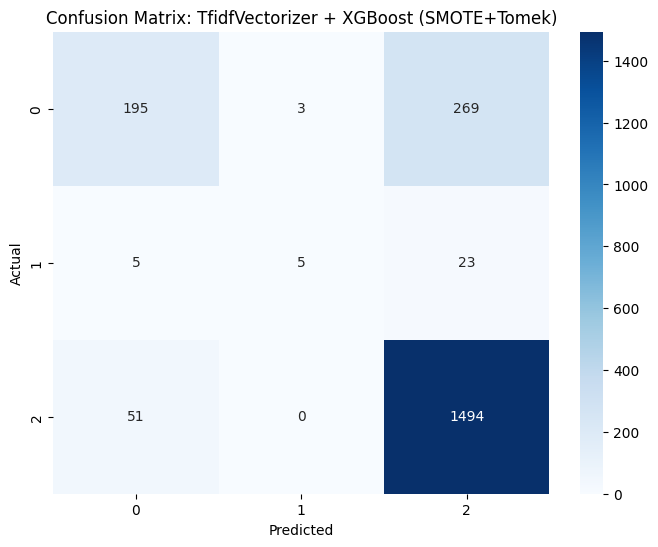

Training: TfidfVectorizer + LightGBM (SMOTE+Tomek)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231150
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 7229
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


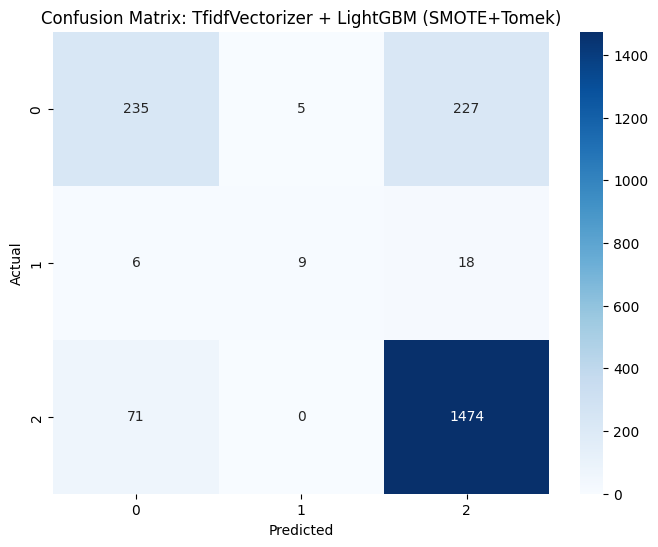

Training: TfidfVectorizer + Logistic Regression (SMOTE+Tomek)


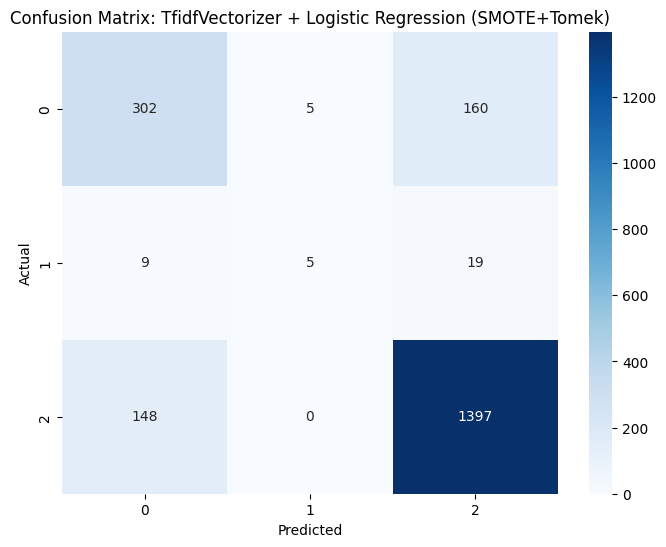

In [26]:
# SMOTE+Tomek resampling
resampling_name = 'SMOTE+Tomek'
resampling_method = smote_tomek
for classifier_name, classifier in classifiers.items():
    print(f'Training: {vectorizer_name} + {classifier_name} ({resampling_name})')
    train_and_evaluate(vectorizer, resampling_method, classifier, vectorizer_name, resampling_name, classifier_name)

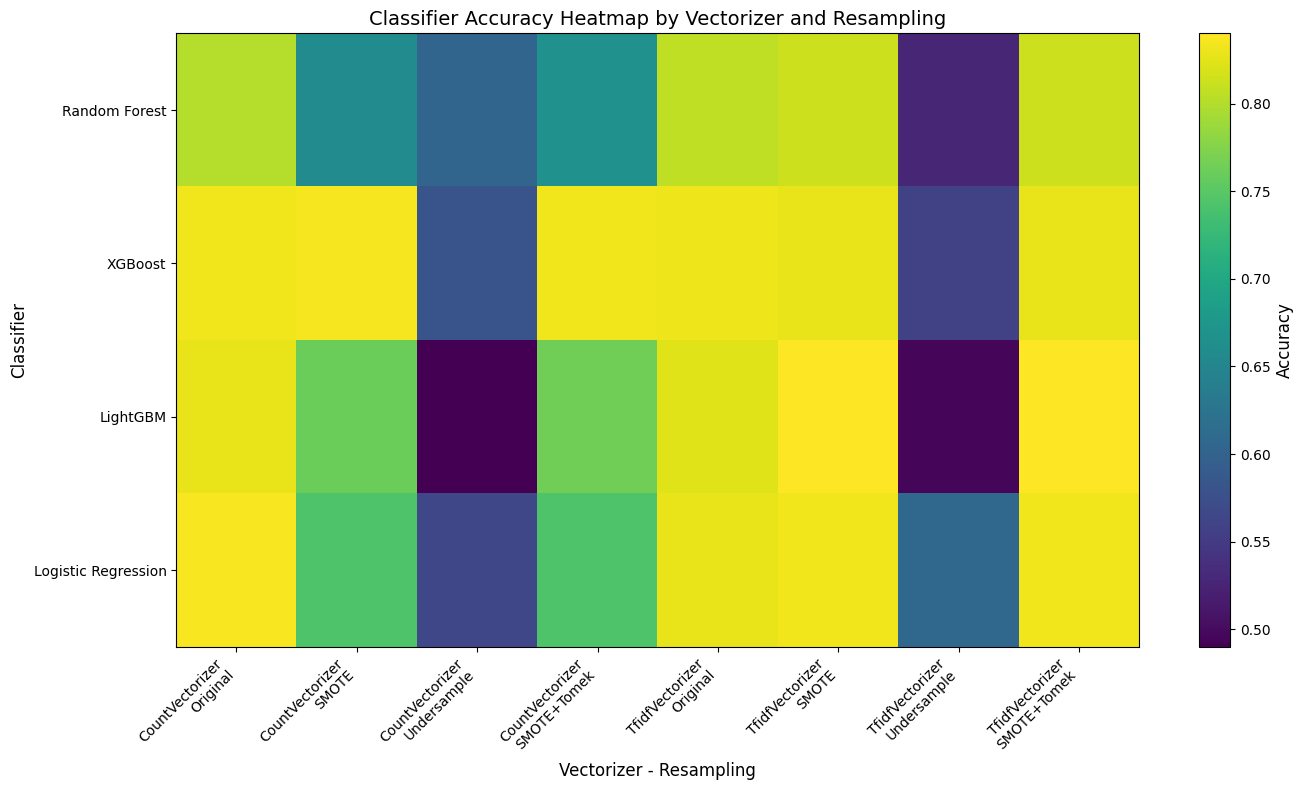

In [35]:
vectorizers = df['Vectorizer'].unique()
resampling_methods = df['Resampling'].unique()
classifiers = df['Classifier'].unique()

fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(vectorizers) * len(resampling_methods)))

heatmap_data = np.zeros((len(classifiers), len(vectorizers) * len(resampling_methods)))
labels = []

for i, vectorizer in enumerate(vectorizers):
    for j, resampling in enumerate(resampling_methods):
        subset = df[(df['Vectorizer'] == vectorizer) & (df['Resampling'] == resampling)]
        if not subset.empty:
            accuracies = subset.set_index('Classifier').reindex(classifiers)['Accuracy'].values
            heatmap_data[:, i * len(resampling_methods) + j] = accuracies
            labels.append(f'{vectorizer}\n{resampling}')

cax = ax.imshow(heatmap_data, cmap='viridis', aspect='auto')

cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Accuracy', fontsize=12)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_yticks(np.arange(len(classifiers)))
ax.set_yticklabels(classifiers, fontsize=10)
ax.set_xlabel('Vectorizer - Resampling', fontsize=12)
ax.set_ylabel('Classifier', fontsize=12)
ax.set_title('Classifier Accuracy Heatmap by Vectorizer and Resampling', fontsize=14)

plt.tight_layout()
plt.show()


## ANN

In [10]:
def build_sparse_ann(input_dim):
    input_layer = Input(shape=(input_dim,), sparse=True)
    x = Dense(128, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

svd = TruncatedSVD(n_components=500, random_state=42)
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.transform(X_test_vec)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reduced, y_train)

y_resampled = to_categorical(y_resampled)
y_test_cat = to_categorical(y_test)


ann = build_sparse_ann(X_resampled.shape[1])
history = ann.fit(
    X_resampled,
    y_resampled,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

y_pred_ann = ann.predict(X_test_reduced)
y_pred_classes = y_pred_ann.argmax(axis=1)

print(classification_report(y_test, y_pred_classes))

Epoch 1/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5459 - loss: 0.9052 - val_accuracy: 0.9576 - val_loss: 0.2691
Epoch 2/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8414 - loss: 0.4160 - val_accuracy: 1.0000 - val_loss: 0.0631
Epoch 3/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8787 - loss: 0.3149 - val_accuracy: 0.9995 - val_loss: 0.0452
Epoch 4/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8948 - loss: 0.2674 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 5/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9147 - loss: 0.2268 - val_accuracy: 1.0000 - val_loss: 0.0118
Epoch 6/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9301 - loss: 0.1951 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 7/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9383 - loss: 0.1714 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 8/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9524 - loss: 0.1423 - val_accuracy: 0.